<b>Data Information</b> <br>
The dataset 'df' contains <b>human trafficking & its related offenses</b> happened in <b>Wisconsin</b> from 2012 to 2018

<b>Data Source</b><br>
<b>Incidents</b><br>
https://crime-data-explorer.fr.cloud.gov/downloads-and-docs <br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [2]:
# Set the data type before reading the csv
data_type = {"AGENCY_NAME": str, 
             "CITY_NAME": str, 
             "CORE_CITY_FLAG": str,
             "COUNTY_NAME": str,
             "COVERED_FLAG": str,
             "DDOCNAME": str,
             "DIRECT_CONTRIBUTOR_FLAG": str,
             "DIVISION_NAME": str,
             "DORMANT_FLAG": str,
             "INCIDENT_NUMBER": str,
             "MIP_FLAG": str,
             "MSA_NAME": str,
             "NCIC_AGENCY_NAME": str,
             "NIBRS_CERT_DATE": str,
             "NIBRS_LEOKA_START_DATE": str,
             "NIBRS_PARTICIPATED": str,
             "NIBRS_START_DATE": str,
             "OFFENSE_GROUP": str,
             "ORIG_FORMAT": str,
             "OFFENDERS_ETHNICITY_NAME": str,
             "PARENT_POP_GROUP_DESC": str,
             "PARTICIPATED": str,
             "PE_REPORTED_FLAG": str,
             "POPULATION_GROUP_CODE": str,
             "POPULATION_SOURCE_FLAG": str,
             "PRIMARY_COUNTY": str,
             "PUBLISHABLE_FLAG": str,
             "PUB_AGENCY_NAME": str,
             "PUB_AGENCY_UNIT": str,
             "REGION_DESC": str,
             "REGION_NAME": str,
             "REPORTING_TYPE": str,
             "SAI": str,
             "SHORT_NAME": str,
             "STATE_NAME": str,
             "STATE_POSTAL_ABBR": str,
             "SUBMISSION_DATE": str,
             "SUBMITTING_AGENCY_NAME": str,
             "SUBMITTING_NAME": str,
             "SUBMITTING_SAI": str,
             "SUBMITTING_STATE_ABBR": str,
             "SUMMARY_RAPE_DEF": str,
             "UCR_AGENCY_NAME": str,
             "VICTIM_RESIDENT_STATUS_CODE": str,
            }

# rename the data path to your data path
df = pd.read_csv('./Data_Source/crawl_data_output/WI.csv', dtype = data_type)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12,15,44,61,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<b> Uses </b><br>
This dataframe is the basis of our analysis, as shown in this notebook. In the later sections, the data is filtered from different perspectives to generate the charts

Before we start the actual analysis, we need to do some data preprocessing so that the data is ready for our analysis.

### Data Preprocessing

Since 2016, a new column 'PRIMARY_COUNTY' has replaced the column 'COUNTY_NAME'. We will need this information for our analysis below. We will copy the data from 'COUNTY_NAME' to 'PRIMARY_COUNTY' using fillna()

There are over 40 unique values for location variable. When the data is too scattered, it would be a good idea to group them into their parent categories. 

In [3]:
# Merge County name column to primary county column
df['PRIMARY_COUNTY'].fillna(df['COUNTY_NAME'], inplace=True)

# capitalize the values
df['PRIMARY_COUNTY'] = df['PRIMARY_COUNTY'].str.capitalize()

# Group locations to location categories by creating a location dictionary
locations_dict = {
'Abandoned/Condemned Structure': 'Abandoned/Condemned Structure',
'Air/Bus/Train Terminal': 'Terminal',
'Amusement Park': 'Amusement Park',
'Arena/Stadium/Fairgrounds/Coliseum': 'Arena/Stadium/Fairgrounds/Coliseum',
'ATM Separate from Bank': 'Bank & related facilities',
'Auto Dealership New/Used': 'Auto Dealership New/Used',
'Bank/Savings and Loan': 'Bank & related facilities',
'Bar/Nightclub': 'Bar/Nightclub',
'Camp/Campground': 'Campsite',
'Church Synagogue/Temple':'Church/Synagogue/Temple/Mosque',
'Church/Synagogue/Temple/Mosque': 'Church/Synagogue/Temple/Mosque',
'Commercial/Office Building': 'Commercial/Office Building',
'Community Center': 'Community Center',
'Construction Site': 'Construction Site',
'Convenience Store': 'Retail',
'Cyberspace':'Cyberspace',
'Daycare Facility':'Daycare Facility',
'Department/Discount Store':'Retail',
'Dock/Wharf/Freight/Modal Terminal':'Terminal',
"Drug Store/Doctor's Office/Hospital": "Drug Store/Doctor's Office/Hospital",
"Drug Store/Dr. s Office/Hospital": "Drug Store/Doctor's Office/Hospital",
"Farm Facility": "Farm Facility",
"Field/Woods":"Field/Woods",
"Government/Public Building":"Government/Public Building",
'Grocery/Supermarket':'Retail',
'Highway/Road/Alley/Street/Sidewalk':'Highway/Road/Ally',
'Highway/Road/Ally':'Highway/Road/Ally',
'Hotel/Motel/Etc.':'Hotel/Motel/Etc.',
"Industrial Site":'Industrial Site',
'Jail/Prison': 'Jail/Prison/Penitentiary/Corrections Facility',
'Jail/Prison/Penitentiary/Corrections Facility': 'Jail/Prison/Penitentiary/Corrections Facility',
'Lake/Waterway': "Lake/Waterway",
'Liquor Store':'Liquor Store',
'Other/Unknown': 'Other/Unknown',
'Park/Playground':'Park/Playground',
'Parking Lot/Garage': 'Parking/Drop Lot/Garage',
'Parking/Drop Lot/Garage':'Parking/Drop Lot/Garage',
'Rental Stor. Facil.':'Rental Storage Facility',
'Rental Storage Facility':'Rental Storage Facility',
'Residence/Home': 'Residence/Home',
'Rest Area':'Rest Area',
'Restaurant':'Restaurant',
'School-College/University':'School/University',
'School-Elementary/Secondary':'School/University',
'Service/Gas Station':'Service/Gas Station',
'Shelter-Mission/Homeless':'Shelter-Mission/Homeless',
'Shopping Mall':'Shopping Mall',
'Specialty Store':'Retail',
'Tribal Lands':'Tribal Lands',
}

df['Location_Category'] = df['LOCATION_NAME'].replace(locations_dict, inplace = False)

### Extract Human Trafficking and related offenses

This dataset contains all offense information. For this project, we are interested in human trafficking and related offenses. We need to do some filtering before moving on to the analysis.

You can use df.query() to do a filtering.

<b>Example: </b> <br>
offenses = df.query("YEAR == 2018")
Running the above code would extract all data in 2018.

<b>Filtering Logic </b><br>
First query all human trafficking offense types, i.e. OFFENSE_TYPE_ID: 59 or 60, and extract the IncidentIDs from this data subset, then look up and extract all observations(records) with matching IncidentIDs from the initial dataframe. The subset contains incidents that other offenses occur along with human trafficking.

In [4]:
# query HT & related offenses
HT_df = df.query("OFFENSE_TYPE_ID == 59 or OFFENSE_TYPE_ID == 60")

# extract the list of IncidentID from OFFENSE_TYPE_ID == 59 or OFFENSE_TYPE_ID == 60
ht_incident_list = HT_df['INCIDENT_ID'].values.tolist()

# extract all rows with specified IncidentIDs from HT Incident List
HT_df = df[df['INCIDENT_ID'].isin(ht_incident_list)]

# Drop the row without OFFENDER_ID 
offenses = HT_df.dropna(subset = ['OFFENDER_ID'])

# Convert OFFENDER_ID column to interger
offenses['OFFENDER_ID'] = offenses['OFFENDER_ID'].astype(int)

## 1. Offenses Analysis

This section provides analysis on offenses

### A. Incident/Offense Type 

An Incident might have one or more offenses. 
This part shows the distribution of incidents.

<b>Incident Types</b>
- Single offenses include 1 offense in an incident
- Multiple offenses include more than 1 offenses in an incident

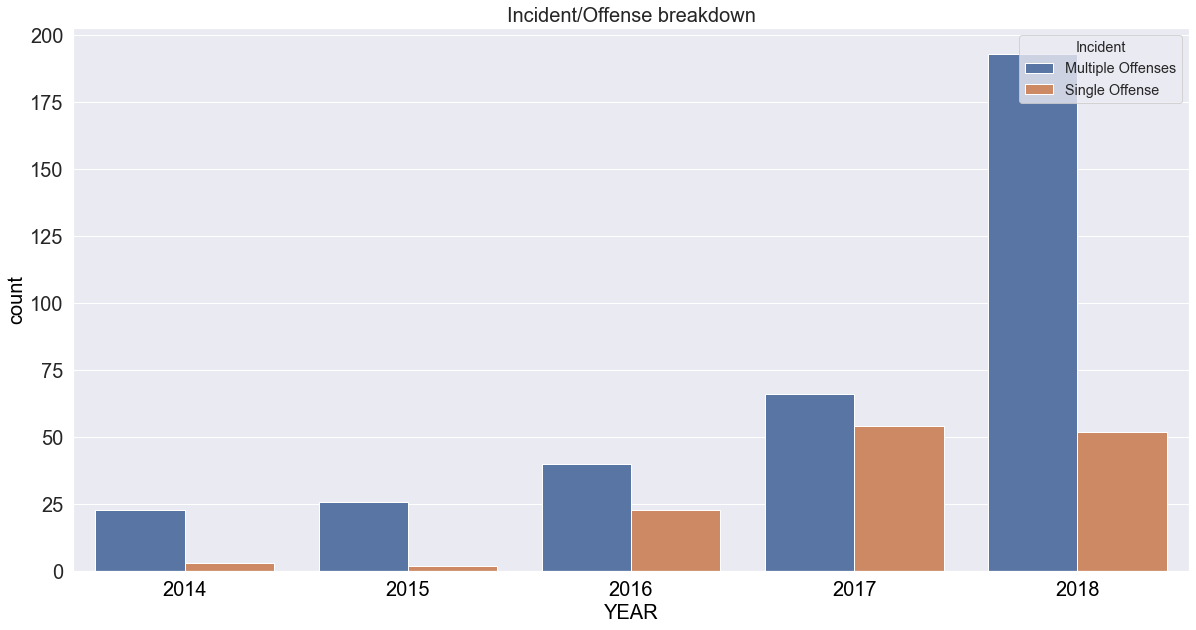

In [5]:
# 1. Count of offense_name in a single incident
offenses['Offense_Count'] = offenses.groupby(['INCIDENT_ID'])['OFFENSE_NAME'].transform('nunique')

# 2. Label the type of Incident according to offense Count
offenses['Incident'] = np.where(offenses['Offense_Count'] == 1, "Single Offense", "Multiple Offenses")

# 3. Plot the graph
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Set visual attributes
sns.set(rc={"font.style":"normal",
            "xtick.color":"black",
            "axes.labelcolor":"black",
            'axes.labelsize':20,
            'figure.figsize':(20.0, 10.0),
            'xtick.labelsize':20,
            'ytick.labelsize':20
           })


ax = sns.countplot(x = 'YEAR', hue = 'Incident', data = offenses)
ax.legend(loc="upper right", title="Incident", title_fontsize="large", fontsize = 'large')

ax.set_title('Incident/Offense breakdown', fontsize = 20)

plt.show()

### B. Top N Offenses

This section shows the top N offenses among all offenses.<br>

<b>NOTES:</b><br>
The default value for N is 10. Change the value if necessary.

If you want to see the top N offenses of Multiple Offenses instead, remove # to run this line of code before doing a groupby <br>
multiple_offenses = offenses[offenses['Incident'] == 'Multiple Offenses']

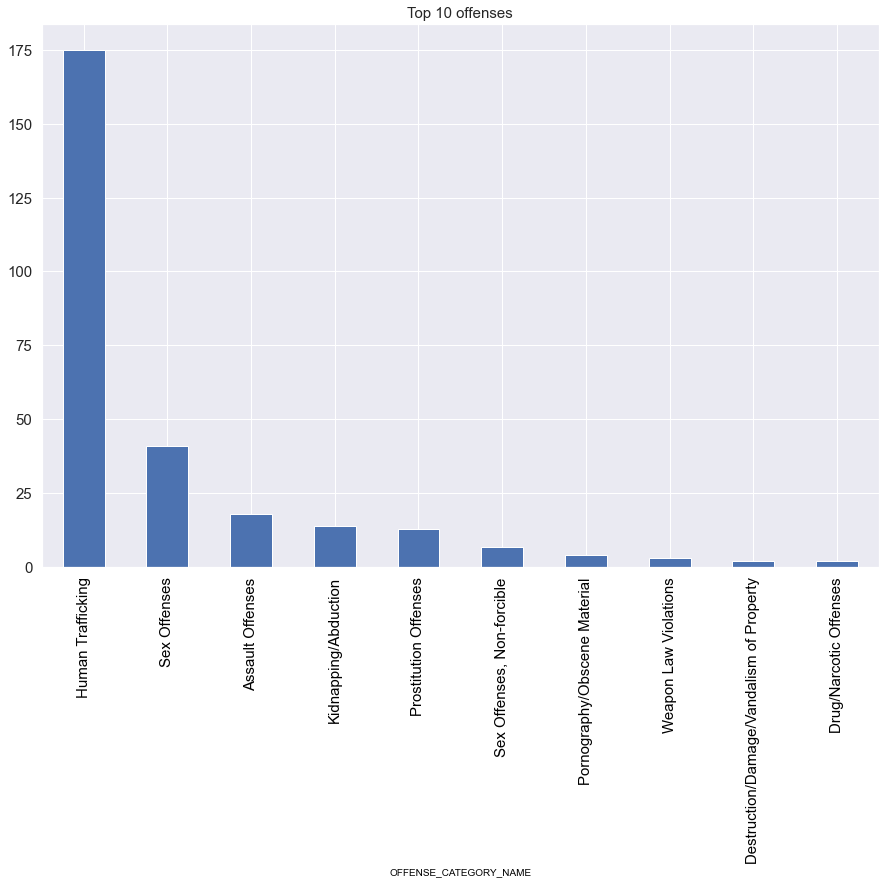

In [6]:
# Set the top N offenses
N = 10

# Uncomment this line to extract those multi offenses only
# multiple_offenses = offenses[offenses['Incident'] == 'Multiple Offenses']

# Do an offenses count
offenses_count = offenses.groupby('OFFENSE_CATEGORY_NAME', as_index = True)['INCIDENT_ID'].nunique()
offenses_count = pd.DataFrame(offenses_count)
offenses_count = offenses_count.reset_index()

# Select the top N offenses
offenses_count_top_N = offenses_count.nlargest(N, 'INCIDENT_ID')

# Plot the top N offenses
offenses_count_top_N.plot(kind = 'bar', x = 'OFFENSE_CATEGORY_NAME', figsize=(15,10), stacked = False, fontsize = 15, 
                          rot = 90)
plt.title('Top '+ str(N) + ' offenses', fontsize=15)
plt.xlabel('OFFENSE_CATEGORY_NAME', fontsize=10)
plt.legend().set_visible(False)

### C. Offense breakdown by Year

This section shows the top N offenses distributions over years.

<b>Instructions</b><br>
Change the value of N in the first line of code to update the change

Text(0.5, 0, 'Year')

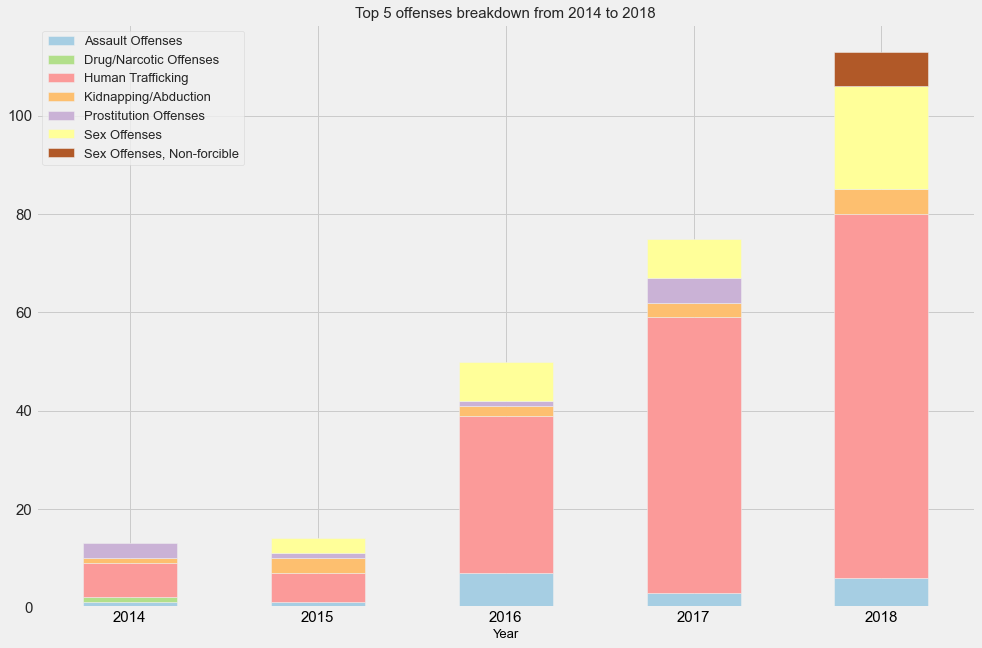

In [7]:
# Set the top N offenses
N = 5

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# Do an offense count by year
offenses_yr = offenses.groupby(['YEAR', 'OFFENSE_CATEGORY_NAME'], as_index = True)['INCIDENT_ID'].nunique()
offenses_yr = pd.DataFrame(offenses_yr).reset_index()
offenses_yr = offenses_yr.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Select the top N offenses
offenses_yr = offenses_yr.groupby(['YEAR']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offenses_yr = offenses_yr.set_index(['YEAR', 'OFFENSE_CATEGORY_NAME']).INCIDENT_COUNT

# Plot the graph
offenses_yr.unstack().plot(kind='bar', stacked=True, figsize=(15, 10),  fontsize = 15, rot = 0, colormap='Paired',
                           legend = True).legend(fontsize = 13, loc = 'best')
plt.title('Top '+ str(N) + ' offenses breakdown from ' + str(HT_df['YEAR'].min()) + ' to ' + 
          str(HT_df['YEAR'].max()), fontsize=15)
plt.xlabel('Year', fontsize=13)

### D. Offenses breakdown by Location

This parts shows the distribution of offense locations.

<b>Instructions</b>
1. Set N value to select the top N offenses.
2. Pick location category(ies) from the options below
3. Subset data by the chosen location category

In [8]:
# Available Location Category for selection if needed
print(offenses['Location_Category'].unique())

['Highway/Road/Ally' 'Residence/Home' 'Hotel/Motel/Etc.'
 'Commercial/Office Building' 'Government/Public Building' 'Other/Unknown'
 'Abandoned/Condemned Structure' 'Retail' 'Cyberspace' 'Restaurant'
 'Park/Playground']


Text(0.5, 1.01, 'Top 3 Offenses breakdown by Location')

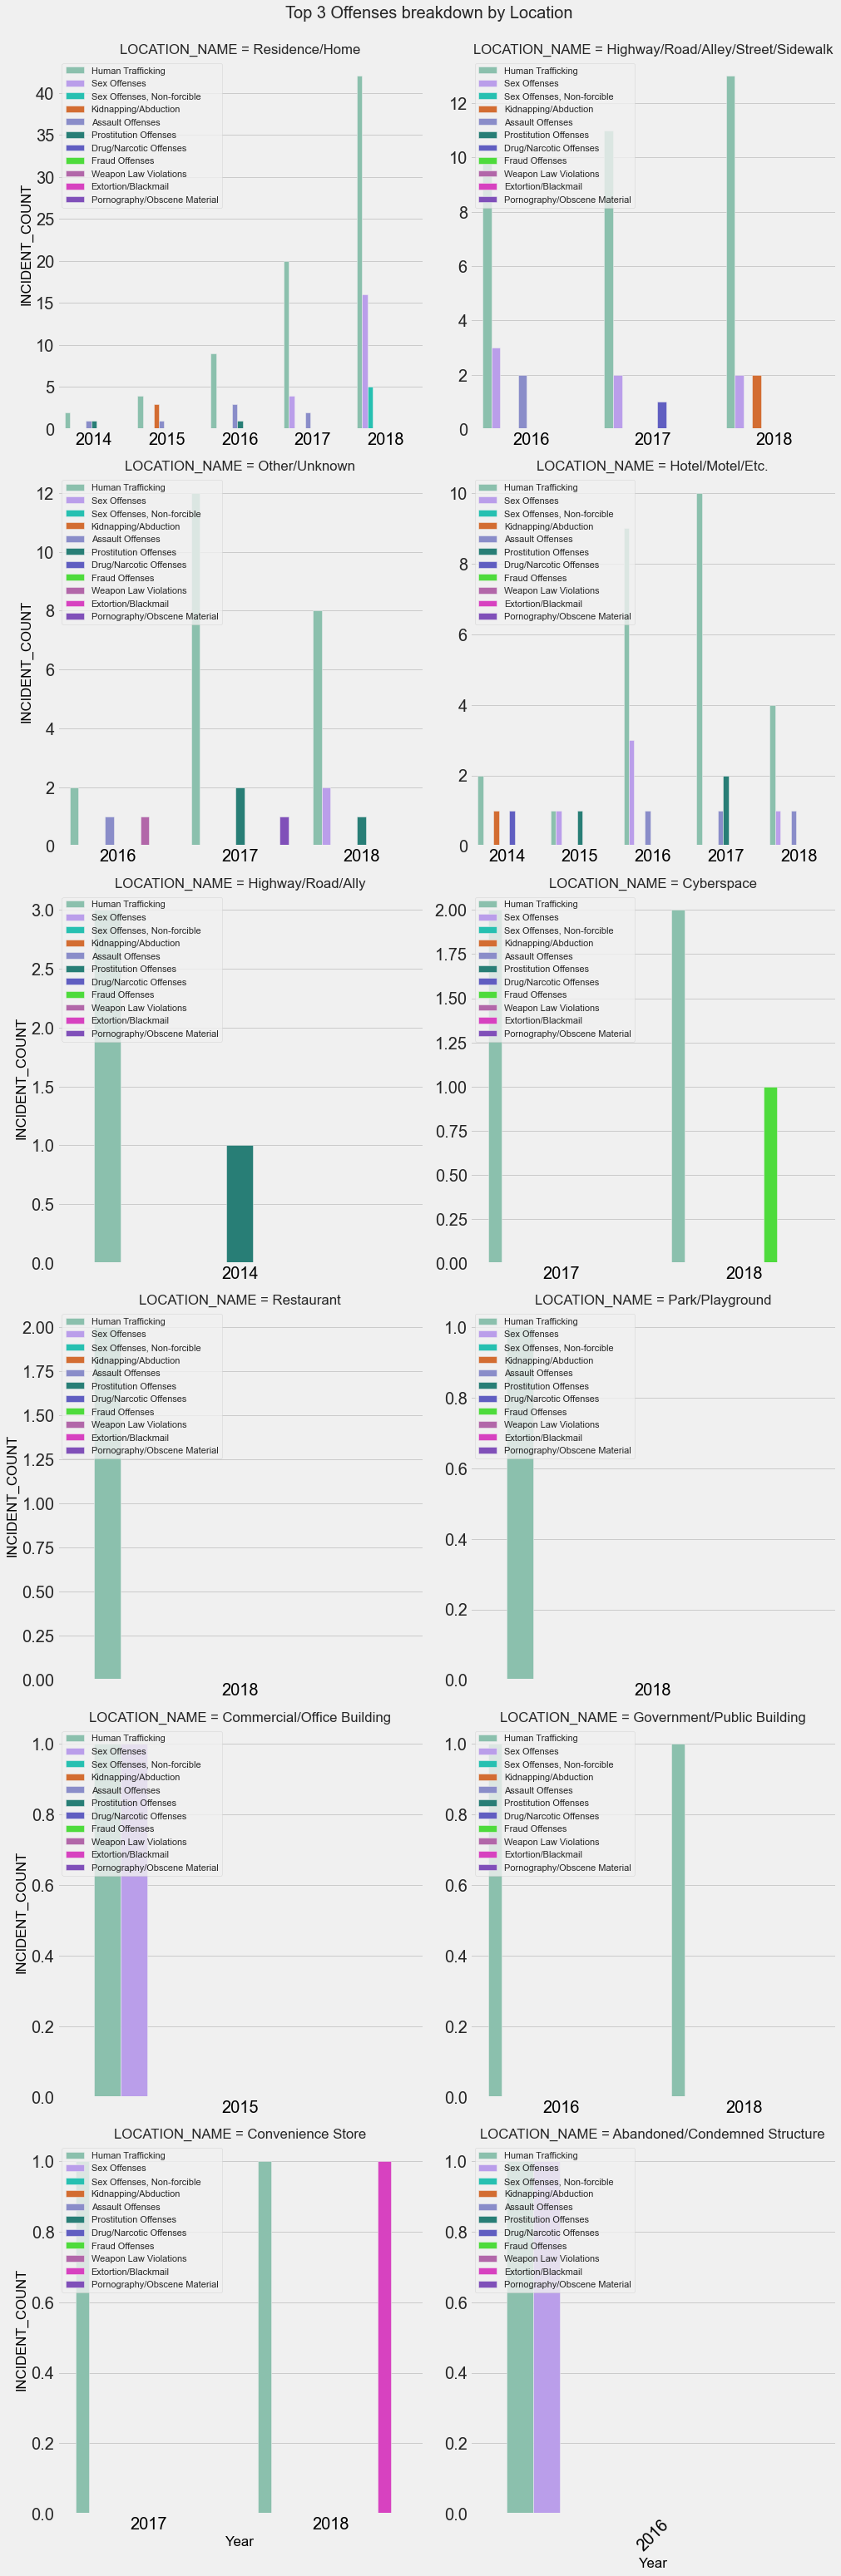

In [9]:
# 1. Set the Top N
N=3

# 2. Select Location Category - refer to the available option above
# 3. Subset data according to your chosen location categories; If you want to see all categories, skip this code
# Uncomment to subset the data
# offense_loc_df = offenses[offenses['Location_Category'] == 'Retail']

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# Do a groupby
# NOTE: replace HT_df with the offense_loc_df, if you need to subset data
offense_loc = offenses.groupby(['YEAR', 'LOCATION_NAME', 'OFFENSE_CATEGORY_NAME'], as_index = True)['INCIDENT_ID'].nunique()
offense_loc = pd.DataFrame(offense_loc).reset_index()
offense_loc = offense_loc.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})


# Extract Top N Offense Type for each location
offense_loc = offense_loc.groupby(['YEAR', 'LOCATION_NAME']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offense_loc = offense_loc.sort_values(by='INCIDENT_COUNT', ascending = False)


# generate random colors
random.seed(5)
generate_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = generate_colors(offense_loc['OFFENSE_CATEGORY_NAME'].nunique())


# Plot
ol = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'LOCATION_NAME', hue = 'OFFENSE_CATEGORY_NAME',
                 data = offense_loc, sharex = False, sharey = False, kind = 'bar', height = 7, aspect=1, col_wrap=2, 
                 legend_out=False, palette=sns.color_palette(colors))

for ax in ol.axes.ravel():
    ax.legend(fontsize=11, loc='upper left')
    
plt.xticks(rotation=45)
ol.set_xlabels('Year')

ol.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by Location', x = 0.5, y= 1.01, fontsize = 20)

### E. Offenses breakdown by County

This shows the top N offenses distribution in each county. <br>

<b>Instructions</b><br>
Change the value of N in the first line of code to update the change

Text(0.5, 1.005, 'Top 5 Offenses breakdown by County')

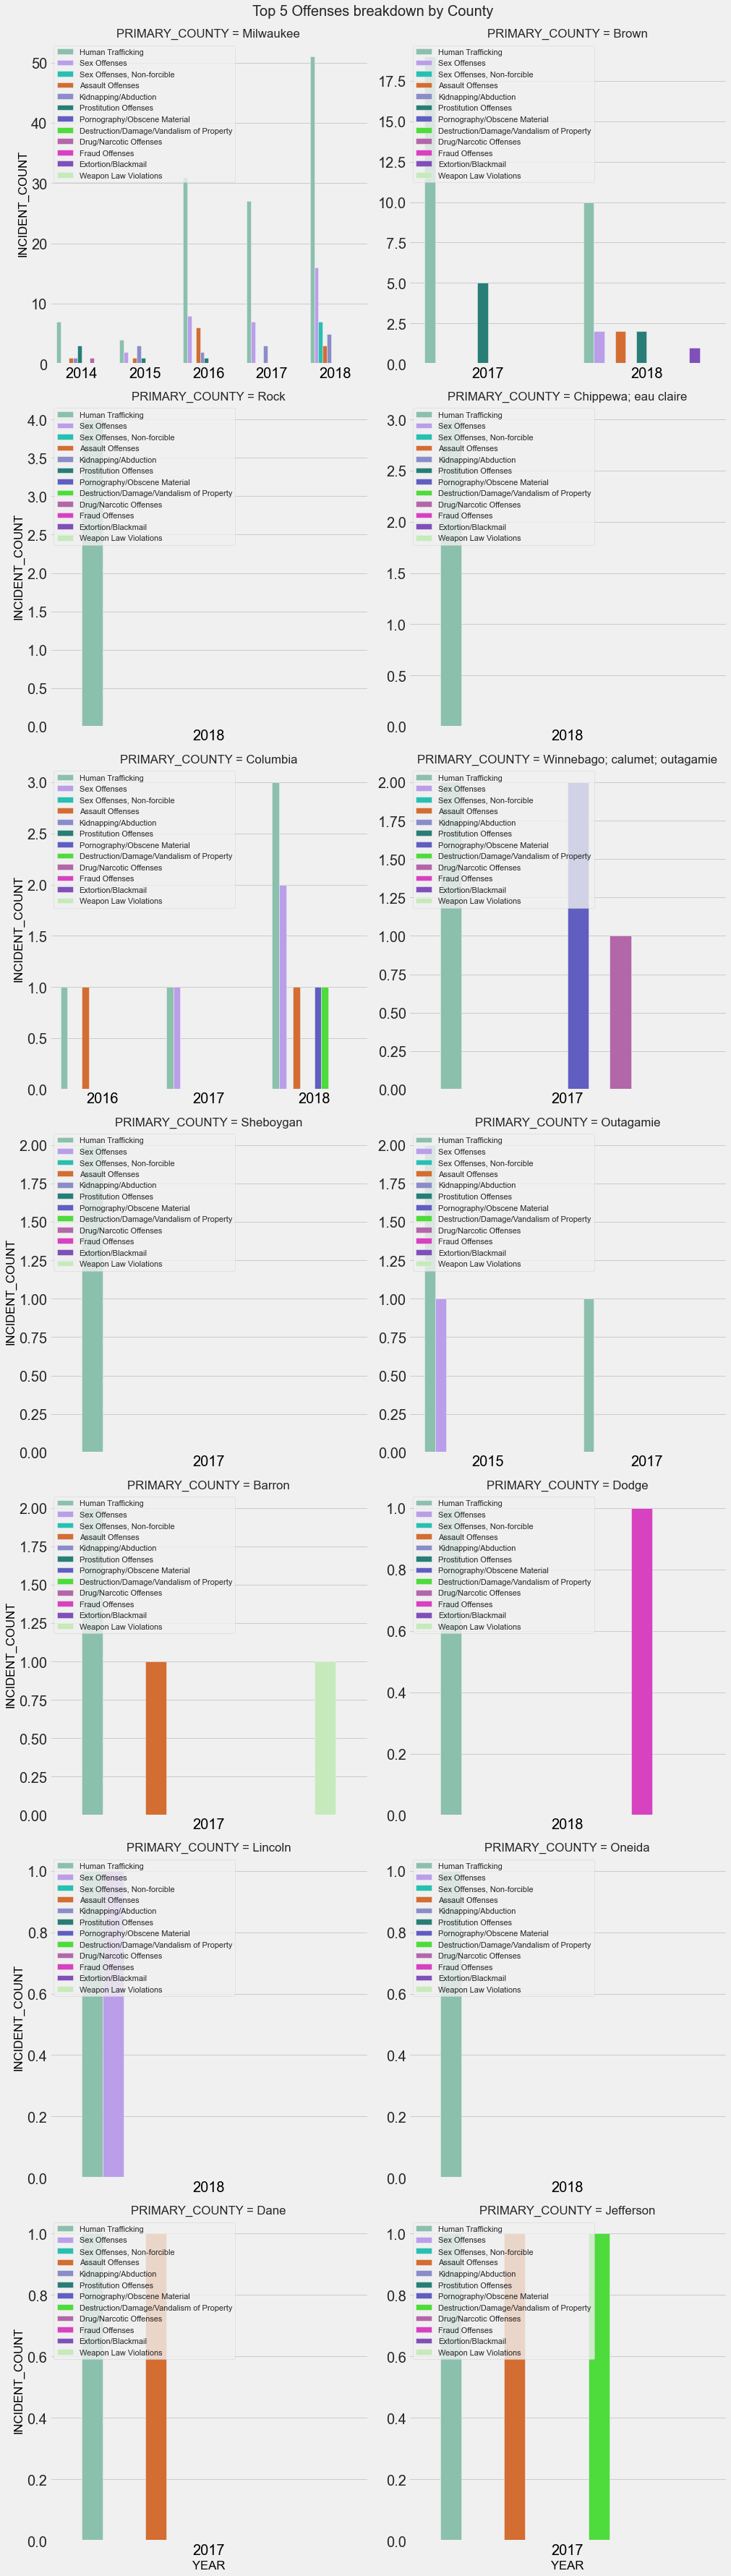

In [10]:
# Set the Top N
N=5

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

offense_county = offenses.groupby(['YEAR', 'PRIMARY_COUNTY', 'OFFENSE_CATEGORY_NAME'], as_index = True)['INCIDENT_ID'].nunique()
offense_county = pd.DataFrame(offense_county).reset_index()
offense_county = offense_county.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Extract Top N Offense Type for each location
offense_county = offense_county.groupby(['YEAR', 'PRIMARY_COUNTY']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offense_county = offense_county.sort_values(by='INCIDENT_COUNT', ascending = False)

# generate random colors
random.seed(5)
generate_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = generate_colors(offense_county['OFFENSE_CATEGORY_NAME'].nunique())

# Plot
oc = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'PRIMARY_COUNTY', hue = 'OFFENSE_CATEGORY_NAME',
                 data = offense_county, sharex = False, sharey = False, kind = 'bar', height = 7, aspect=1, col_wrap=2, 
                 legend_out=False, palette=sns.color_palette(colors))

for ax in oc.axes.ravel():
    ax.legend(fontsize=11, loc='upper left')

oc.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by County', x = 0.5, y= 1.005, fontsize = 20)

### F. Offenses breakdown by City

This chart shows the top N offenses distribution by cities of selected county. <br>

<b>Instructions</b>
1. Set N value to select the top N offenses.
2. Pick a county
3. Subset data by the chosen county

Text(0.5, 1.005, 'Top 3 Offenses breakdown by City')

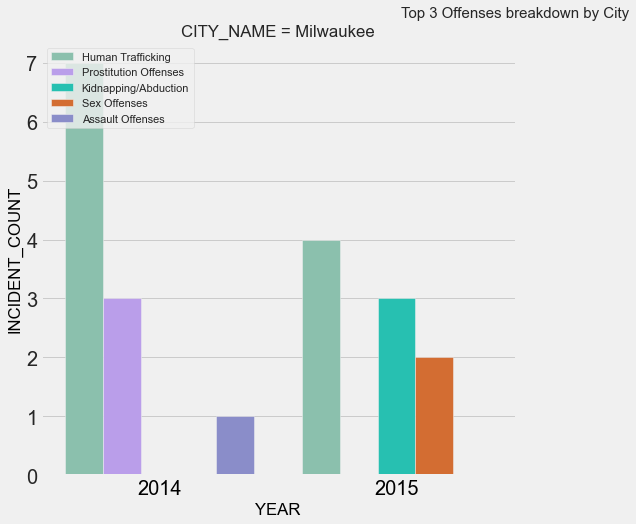

In [11]:
# 1. Set the N value
N=3

# 2. Select a County
# 3. Subset the data by your chosen county; If you need to see all cities, skips this line
# comment out to see all cities
county_df = offenses[offenses['PRIMARY_COUNTY'] == 'Milwaukee']

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# NOTE: replace 'county_df' with HT_df for all cities
offense_city = county_df.groupby(['YEAR', 'CITY_NAME', 'OFFENSE_CATEGORY_NAME'], as_index = True)['INCIDENT_ID'].nunique()
offense_city = pd.DataFrame(offense_city).reset_index()
offense_city = offense_city.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Extract Top N Offense Type for each location
offense_city = offense_city.groupby(['YEAR', 'CITY_NAME']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offense_city = offense_city.sort_values(by='INCIDENT_COUNT', ascending = False)

# generate random colors
random.seed(5)
generate_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = generate_colors(offense_city['OFFENSE_CATEGORY_NAME'].nunique())

# Plot
oc = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'CITY_NAME', hue = 'OFFENSE_CATEGORY_NAME',
                 data = offense_city, sharex = False, sharey = False, kind = 'bar', height = 7, aspect=1, col_wrap=2, 
                 legend_out=False, palette=sns.color_palette(colors))

for ax in oc.axes.ravel():
    ax.legend(fontsize=11, loc='upper left')

oc.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by City', x = 0.5, y= 1.005, fontsize = 15)

## 2. Offenders Demographic Analysis

This section shows the demographic infomation of offenders.

In [12]:
# Extract data columns about offenders
offenders_df = HT_df[['YEAR', 'AGENCY_NAME', 'AGENCY_TYPE_NAME', 'CITY_NAME', 'INCIDENT_DATE',  
                      'LOCATION_NAME', 'POPULATION', 'SHORT_NAME', 'STATE_ABBR', 'OFFENDERS_AGE_ID', 
                      'OFFENDERS_AGE_NAME', 'OFFENDERS_AGE_NUM', 'OFFENDERS_ETHNICITY_NAME', 'OFFENDER_ID', 
                      'OFFENDERS_RACE_DESC', 'OFFENDER_SEQ_NUM', 'OFFENDERS_SEX_CODE', 'INCIDENT_ID', 
                      'OFFENSE_CATEGORY_NAME', 'OFFENSE_GROUP', 'OFFENSE_NAME']]

### A. Offense breakdown by Offender Gender

This charts shows offenses distribution by offenders gender.<br> 
<b>NOTE</b><br>
Unknown gender is by default excluded. Use # to comment out below line to include the unknown gender:<br>
offenders_sex = offenders_sex[offenders_sex['OFFENDERS_SEX_CODE'] != 'U']


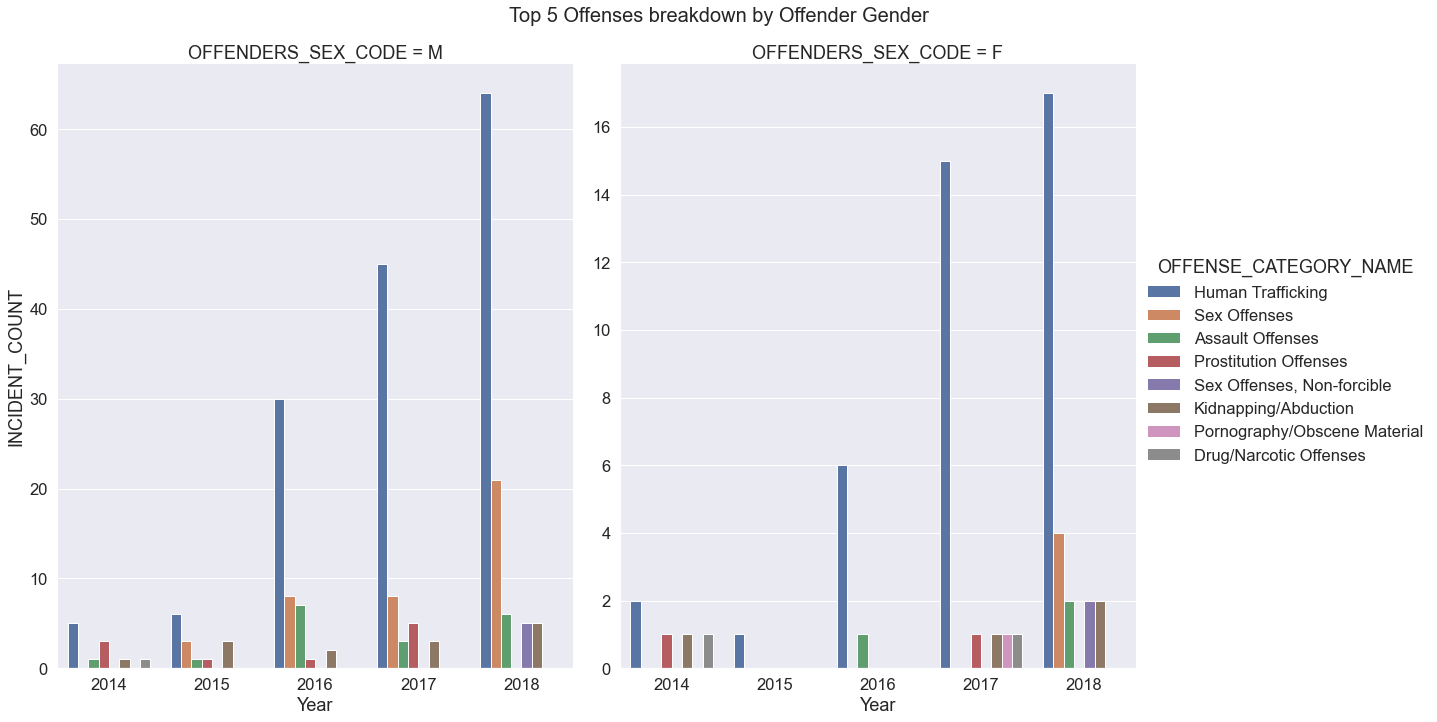

In [13]:
# Set the Top N
N=5 

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(10,1)})
sns.set(font_scale=1.5)

# Comment out this line to include unknown gender
offenders_sex = offenders_df.copy()
offenders_sex = offenders_sex[offenders_sex['OFFENDERS_SEX_CODE'] != 'U']

# Group the data by Year, offense categories and gender
offenders_sex = offenders_sex.groupby(['YEAR', 'OFFENSE_CATEGORY_NAME', 'OFFENDERS_SEX_CODE'], as_index = True)['INCIDENT_ID'].nunique()
offenders_sex = pd.DataFrame(offenders_sex).reset_index()
offenders_sex = offenders_sex.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Extract the top N offenses
offenders_sex = offenders_sex.groupby(['YEAR', 'OFFENDERS_SEX_CODE']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offenders_sex = offenders_sex.sort_values(by='INCIDENT_COUNT', ascending = False)

# Plot
fg = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'OFFENDERS_SEX_CODE', hue = 'OFFENSE_CATEGORY_NAME',
                 data=offenders_sex, sharex = False, sharey = False, kind = 'bar', height = 10, aspect=.8, col_wrap=2, 
                 legend_out=True)

fg.set_xlabels('Year')

plt.subplots_adjust(top=0.9)
fg.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by Offender Gender', fontsize = 20)

plt.show()

### B. Offense breakdown by Offender Age Group

This chart shows offenses distribution by offenders age group.<br>

I created a age_group column for this chart using both OFFENDERS_AGE_ID and OFFENDERS_AGE_NUM columns in the dataset.

<b>Age Groups</b> <br>
7-364 Days Old, 1-3 Years Old, 4-10 Years Old, 11-17 Years Old, 18-30 Years Old, 31-50 Years Old, 51-70 Years Old,
71-98 Years Old, Over 98 Years Old

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


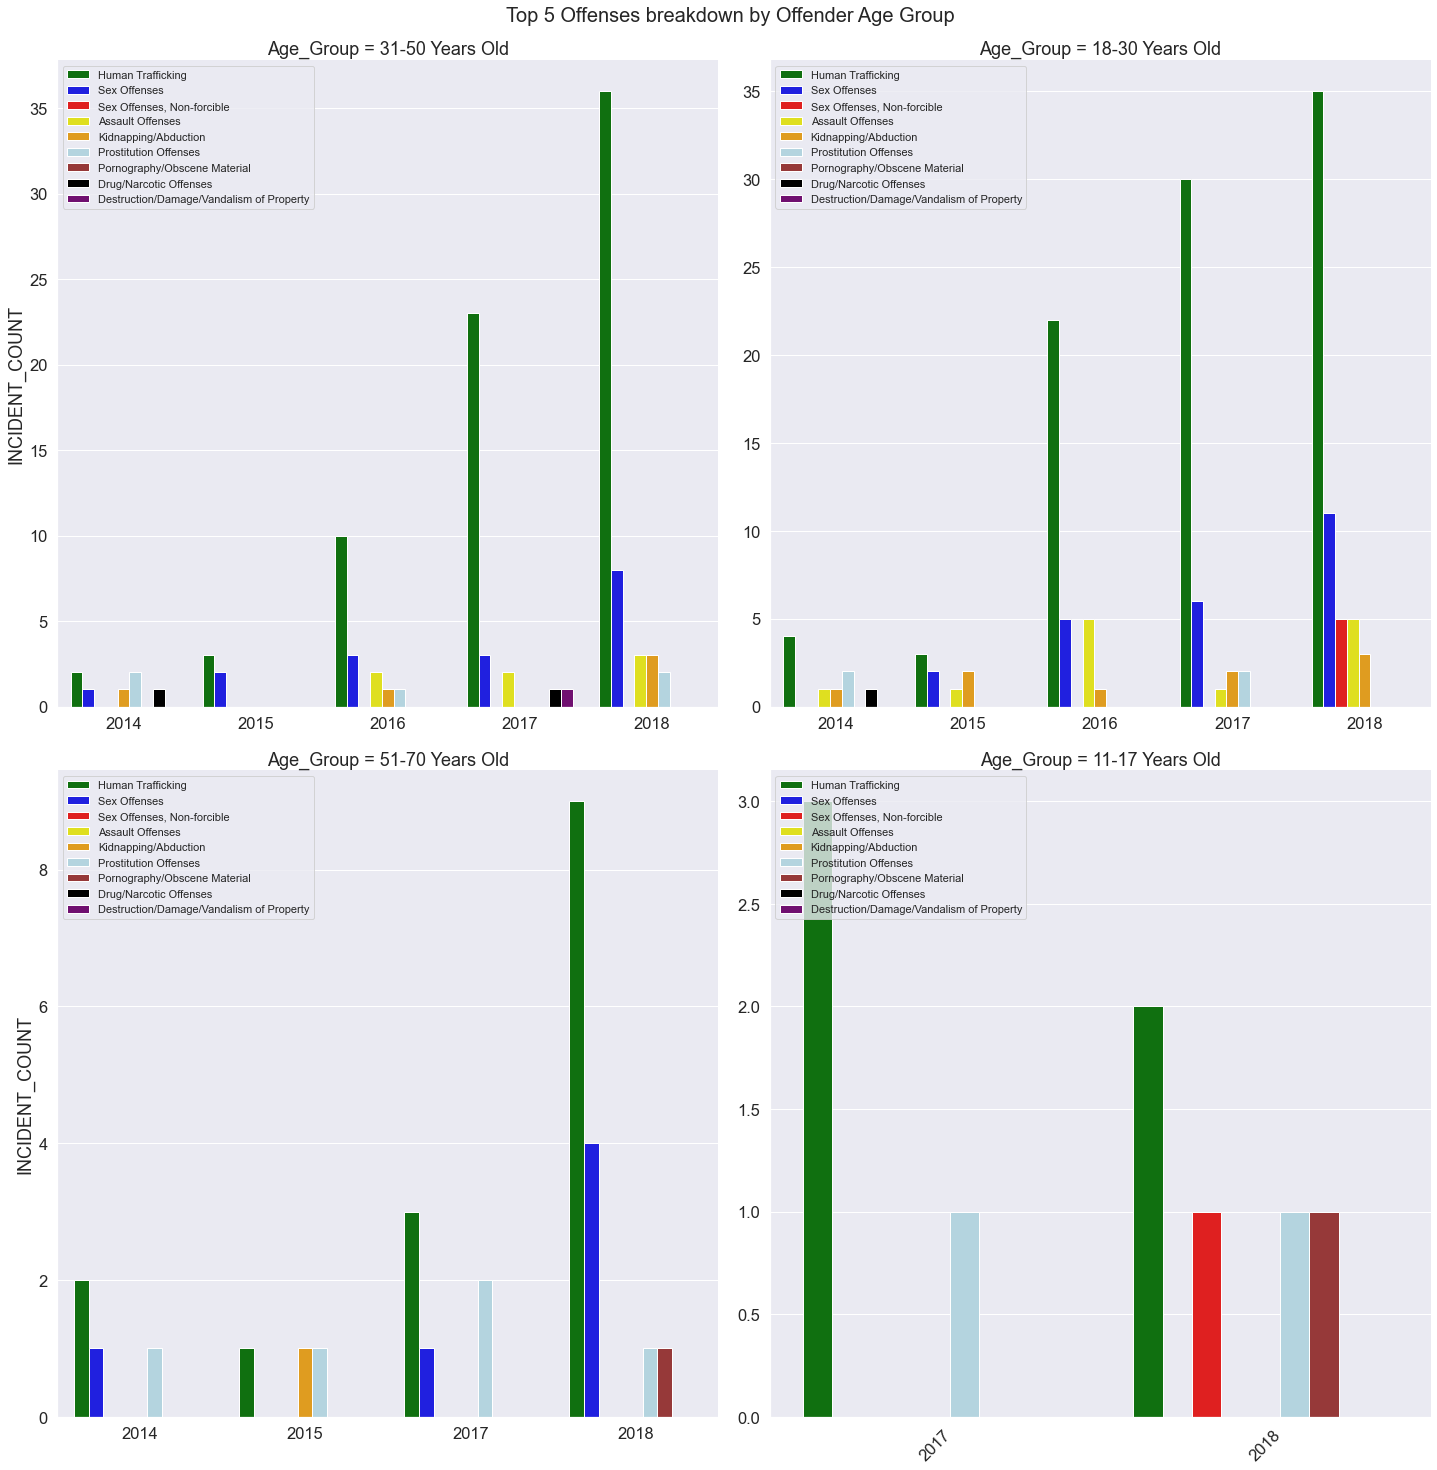

In [14]:
# Group offenders by age
AGE_ID_BABIES = 3
AGE_ID_UNKNOWN = 4
AGE_ID_ADULTS = 5
AGE_ID_ELDERLY = 6

def find_offender_age_group(df_row):
    age_id = df_row['OFFENDERS_AGE_ID']
    age_num = df_row['OFFENDERS_AGE_NUM']
    
    if age_id == AGE_ID_BABIES:
        return '7-364 Days Old'
    elif age_id == AGE_ID_UNKNOWN:
        return 'Unknown'
    elif age_id == AGE_ID_ELDERLY:
        return 'Over 98 Years Old'
    elif age_id == AGE_ID_ADULTS:
        if age_num <= 3:
            return '1-3 Years Old'
        elif age_num <= 10:
            return '4-10 Years Old'
        elif age_num < 18:
            return '11-17 Years Old'
        elif age_num <= 30:
            return '18-30 Years Old'
        elif age_num <= 50:
            return '31-50 Years Old'
        elif age_num <= 70:
            return '51-70 Years Old'
        elif age_num <= 98:
            return '71-98 Years Old'
    else:
        return "No Information"


    
# Find Age Group
offenders_df.loc[:, 'Age_Group'] = offenders_df.apply(find_offender_age_group, axis = 1)

# drop Age Group == Unknown and Age Group == No Information
offenders_age_group = offenders_df[offenders_df['Age_Group'] != 'Unknown']
offenders_age_group = offenders_age_group[offenders_age_group['Age_Group'] != 'No Information']

# Set the top N
N=5 

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('seaborn-bright')

sns.set(rc={'figure.figsize':(10,1)})
sns.set(font_scale=1.5)

# Group the data
offenders_age_group = offenders_age_group.groupby(['YEAR', 'OFFENSE_CATEGORY_NAME', 'Age_Group'], as_index = True)['INCIDENT_ID'].nunique()
offenders_age_group = pd.DataFrame(offenders_age_group).reset_index()
offenders_age_group = offenders_age_group.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Select the top N and sort values
offenders_age_group = offenders_age_group.groupby(['YEAR', 'Age_Group']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
offenders_age_group = offenders_age_group.sort_values(by='INCIDENT_COUNT', ascending = False)

# Plot the data
g = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'Age_Group', hue = 'OFFENSE_CATEGORY_NAME', 
                data=offenders_age_group, kind = 'bar', height = 10, aspect=1, col_wrap=2, sharex = False, 
                sharey=False, legend_out=False, palette=sns.color_palette(['green', 'blue', 'red', 'yellow', 'orange',
                                                                           'lightblue', 'brown', 'black', 'purple', 
                                                                           'lightgreen', 'pink']))

        
for ax in g.axes.ravel():
    ax.legend(fontsize=11, loc='upper left')
    

plt.xticks(rotation=45)
g.set_xlabels('')
g.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by Offender Age Group', x = 0.5, y= 1.01, fontsize = 20)

plt.show()

## 3. Victims demographic Analysis

This section shows the demographic infomation of victims.

In [15]:
# Extract victims data
victims_df = HT_df[['YEAR', 'AGENCY_NAME', 'AGENCY_TYPE_NAME', 'CITY_NAME', 'INCIDENT_DATE', 'LOCATION_NAME', 
                 'POPULATION', 'SHORT_NAME', 'STATE_ABBR', 'VICTIM_AGE_ID', 'VICTIM_AGE_NAME', 'VICTIM_AGE_NUM', 
                 'VICTIM_ETHNICITY_NAME', 'VICTIM_ID', 'VICTIM_RACE_DESC', 'VICTIM_RESIDENT_STATUS_CODE',
                 'VICTIM_SEQ_NUM', 'VICTIM_SEX_CODE', 'VICTIM_TYPE_NAME', 'INCIDENT_ID', 'OFFENSE_CATEGORY_NAME',
                 'OFFENSE_GROUP', 'OFFENSE_NAME']]

### A. Offense breakdown by Victim Gender

This chart shows offenses distribution by victims gender.<br>
<b>NOTE</b><br>
Unknown gender is by default excluded. Use # to comment out below line to include the unknown gender:<br>
victims_sex = victims_sex[victims_sex['OFFENDERS_SEX_CODE'] != 'U']

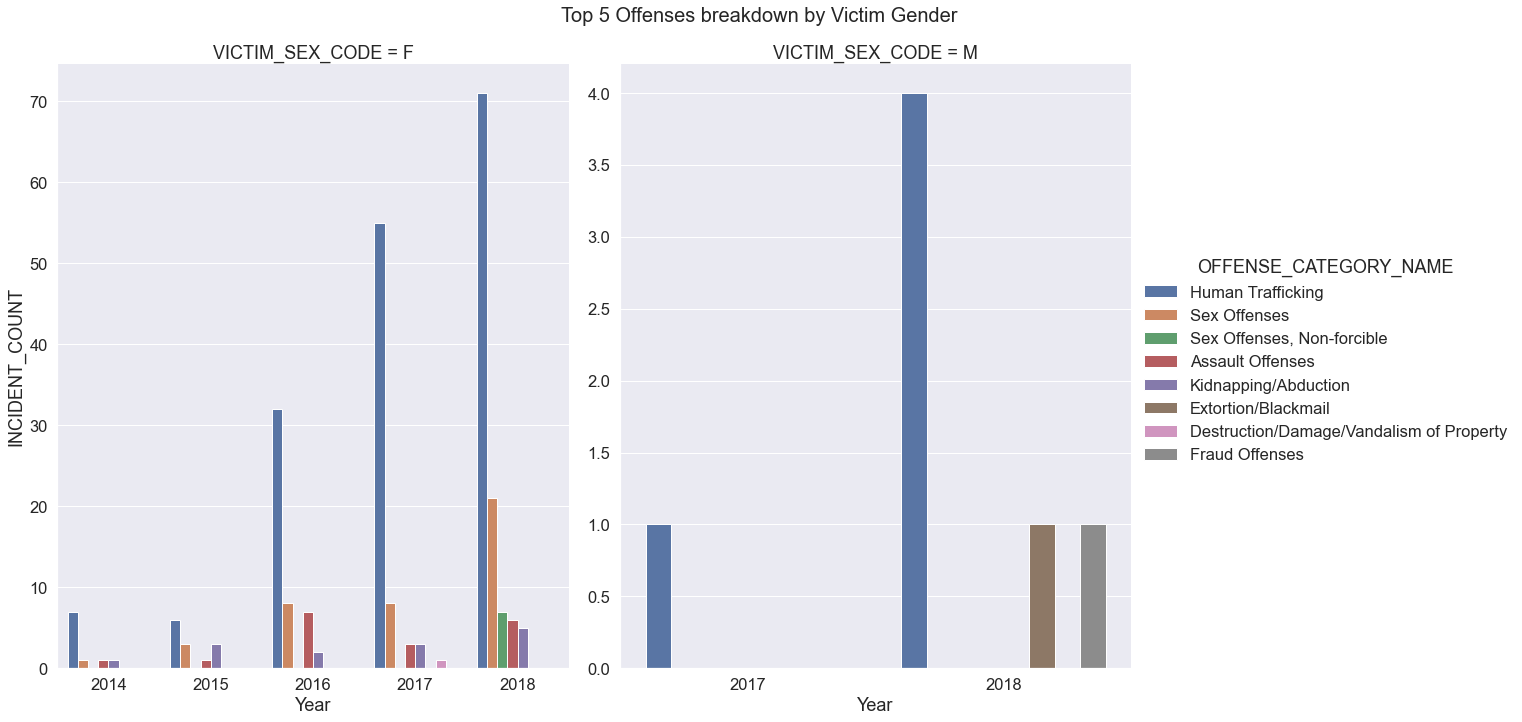

In [16]:
# Set the Top N
N=5 

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

sns.set(rc={'figure.figsize':(10,1)})
sns.set(font_scale=1.5)

# Exclude the unknown victim genders
# Comment out this line to include unknown gender
victims_sex = victims_df.copy()
victims_sex = victims_sex[victims_sex['VICTIM_SEX_CODE'] != 'U']

# group data
victims_sex = victims_sex.groupby(['YEAR', 'OFFENSE_CATEGORY_NAME', 'VICTIM_SEX_CODE'], as_index = True)['INCIDENT_ID'].nunique()
victims_sex = pd.DataFrame(victims_sex).reset_index()
victims_sex = victims_sex.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

# Select the top N and sort values
victims_sex = victims_sex.groupby(['YEAR', 'VICTIM_SEX_CODE']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
victims_sex = victims_sex.sort_values(by='INCIDENT_COUNT', ascending = False)

# Plot
fg = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'VICTIM_SEX_CODE', hue = 'OFFENSE_CATEGORY_NAME',
                 data=victims_sex, sharex = False, sharey = False, kind = 'bar', height = 10, aspect=.8, col_wrap=2, 
                 legend_out=True)

fg.set_xlabels('Year')

plt.subplots_adjust(top=0.9)
fg.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by Victim Gender', fontsize = 20)

plt.show()

### B. Offense breakdown by Victim Age Group

This charts shows offenses distribution by victims age group.

I created a age_group column for this chart using both VICTIM_AGE_ID and VICTIM_AGE_NUM columns in the dataset.

<b>Age Groups</b><br>
7-364 Days Old, 1-3 Years Old, 4-10 Years Old, 11-17 Years Old, 18-30 Years Old, 31-50 Years Old, 51-70 Years Old, 71-98 Years Old, Over 98 Years Old


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


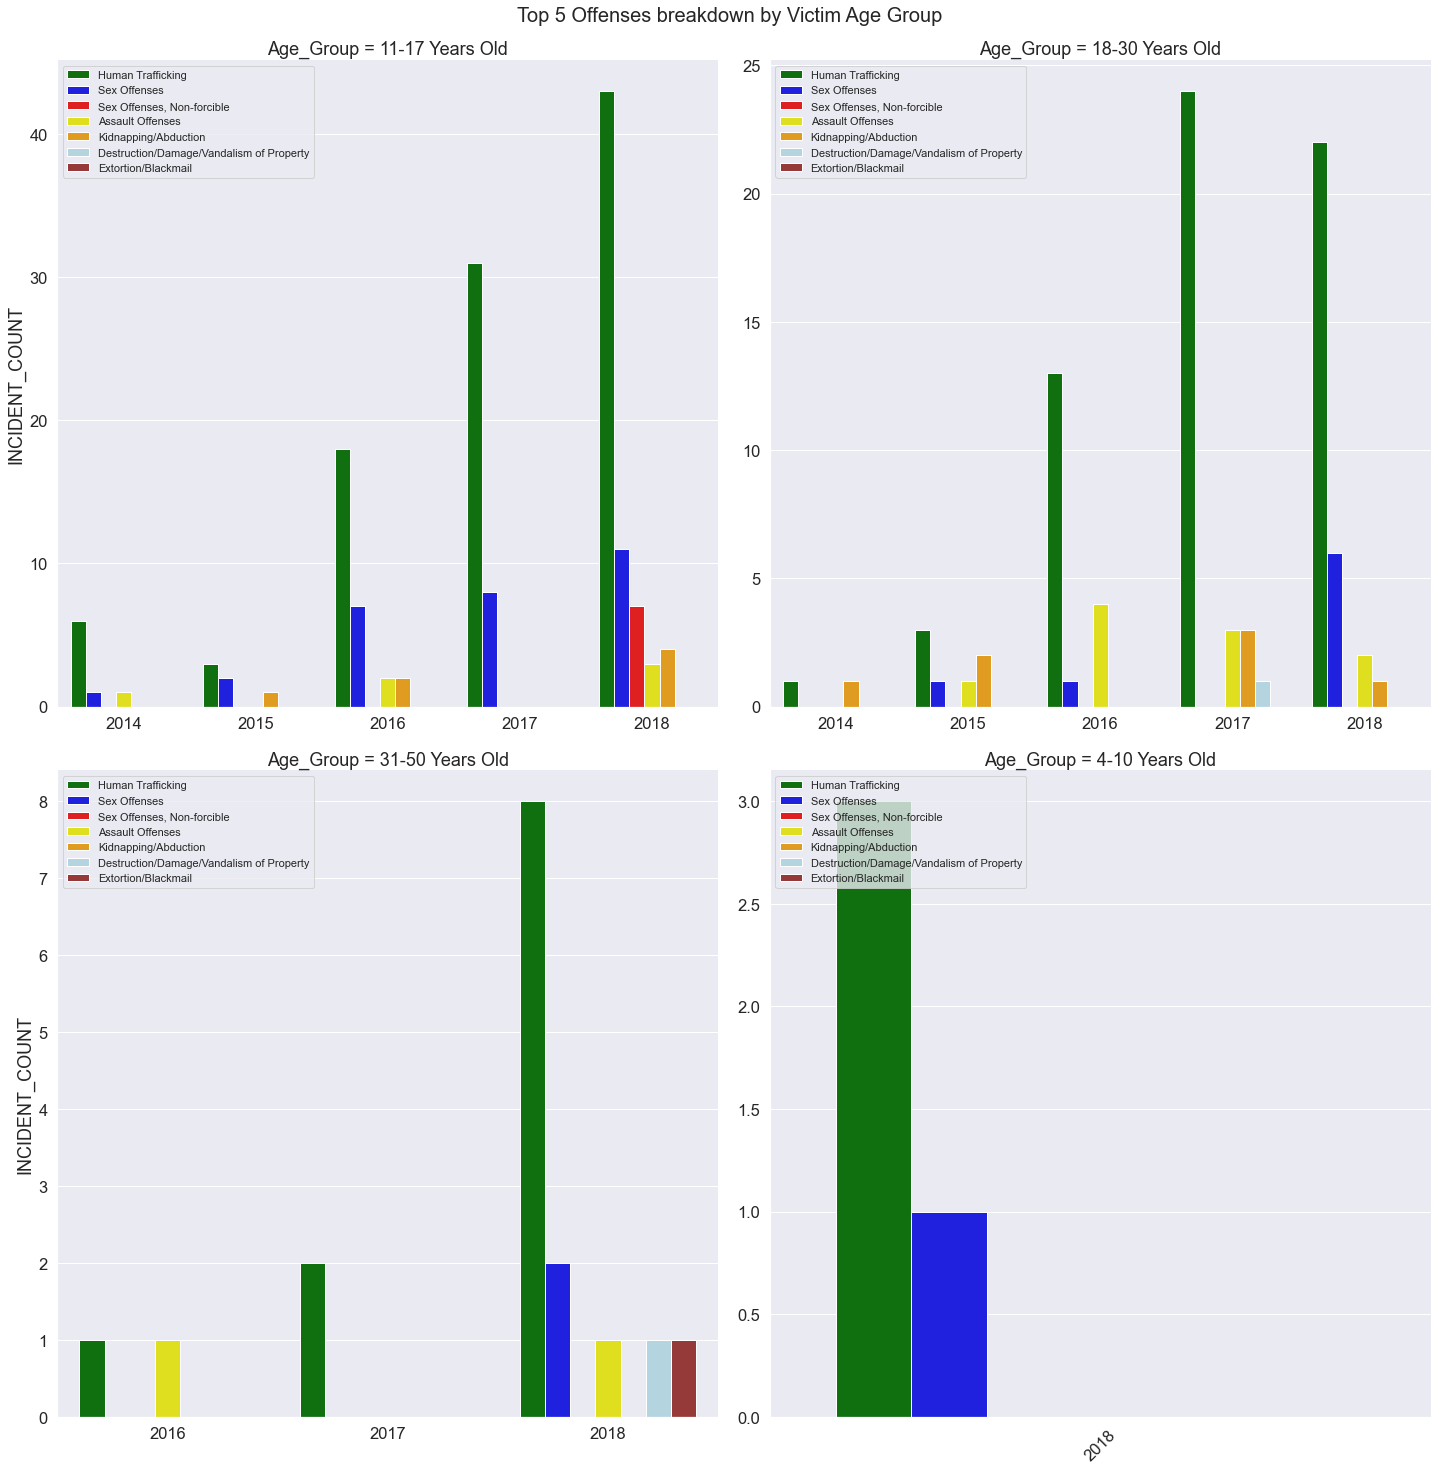

In [17]:
# Group victims by age
AGE_ID_BABIES = 3
AGE_ID_UNKNOWN = 4
AGE_ID_ADULTS = 5
AGE_ID_ELDERLY = 6

def find_victim_age_group(df_row):
    age_id = df_row['VICTIM_AGE_ID']
    age_num = df_row['VICTIM_AGE_NUM']
    
    if age_id == AGE_ID_BABIES:
        return '7-364 Days Old'
    elif age_id == AGE_ID_UNKNOWN:
        return 'Unknown'
    elif age_id == AGE_ID_ELDERLY:
        return 'Over 98 Years Old'
    elif age_id == AGE_ID_ADULTS:
        if age_num <= 3:
            return '1-3 Years Old'
        elif age_num <= 10:
            return '4-10 Years Old'
        elif age_num < 18:
            return '11-17 Years Old'
        elif age_num <= 30:
            return '18-30 Years Old'
        elif age_num <= 50:
            return '31-50 Years Old'
        elif age_num <= 70:
            return '51-70 Years Old'
        elif age_num <= 98:
            return '71-98 Years Old'
    else:
        return "No Information"
    
    
    
victims_df.loc[:, 'Age_Group'] = victims_df.apply(find_victim_age_group, axis = 1)

# drop Age Group == Unknown and Age Group == No Information
vic_age_group = victims_df[victims_df['Age_Group'] != 'Unknown']
vic_age_group = vic_age_group[vic_age_group['Age_Group'] != 'No Information']

# Set the top N
N=5 

# Set the bar graph style
%matplotlib inline
matplotlib.style.use('seaborn-bright')

sns.set(rc={'figure.figsize':(10,1)})
sns.set(font_scale=1.5)

# groupby
vic_age_group = vic_age_group.groupby(['YEAR', 'OFFENSE_CATEGORY_NAME', 'Age_Group'], as_index = True)['INCIDENT_ID'].nunique()
vic_age_group = pd.DataFrame(vic_age_group).reset_index()
vic_age_group = vic_age_group.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})

vic_age_group = vic_age_group.groupby(['YEAR', 'Age_Group']).apply(lambda x: x.nlargest(N, ['INCIDENT_COUNT'])).reset_index(drop=True)
vic_age_group = vic_age_group.sort_values(by='INCIDENT_COUNT', ascending = False)

# plot
g = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'Age_Group', hue = 'OFFENSE_CATEGORY_NAME', 
                data=vic_age_group, kind = 'bar', height = 10, aspect=1, col_wrap=2, sharex = False, sharey=False,
                legend_out=False, palette=sns.color_palette(['green', 'blue', 'red', 'yellow', 'orange', 'lightblue', 
                                                             'brown', 'black', 'purple', 'lightgreen', 'pink']))

        
for ax in g.axes.ravel():
    ax.legend(fontsize=11, loc='upper left')
    

plt.xticks(rotation=45)
g.set_xlabels('')
g.fig.suptitle('Top ' + str(N) + ' Offenses breakdown by Victim Age Group', x = 0.5, y= 1.01, fontsize = 20)

plt.show()

### C. Offenses breakdown by Victim Age Group & Gender

This part shows the trend of distribution of offenses by victim age group and gender

Text(0.5, 1.005, 'Offense breakdown by Victim Age & Gender')

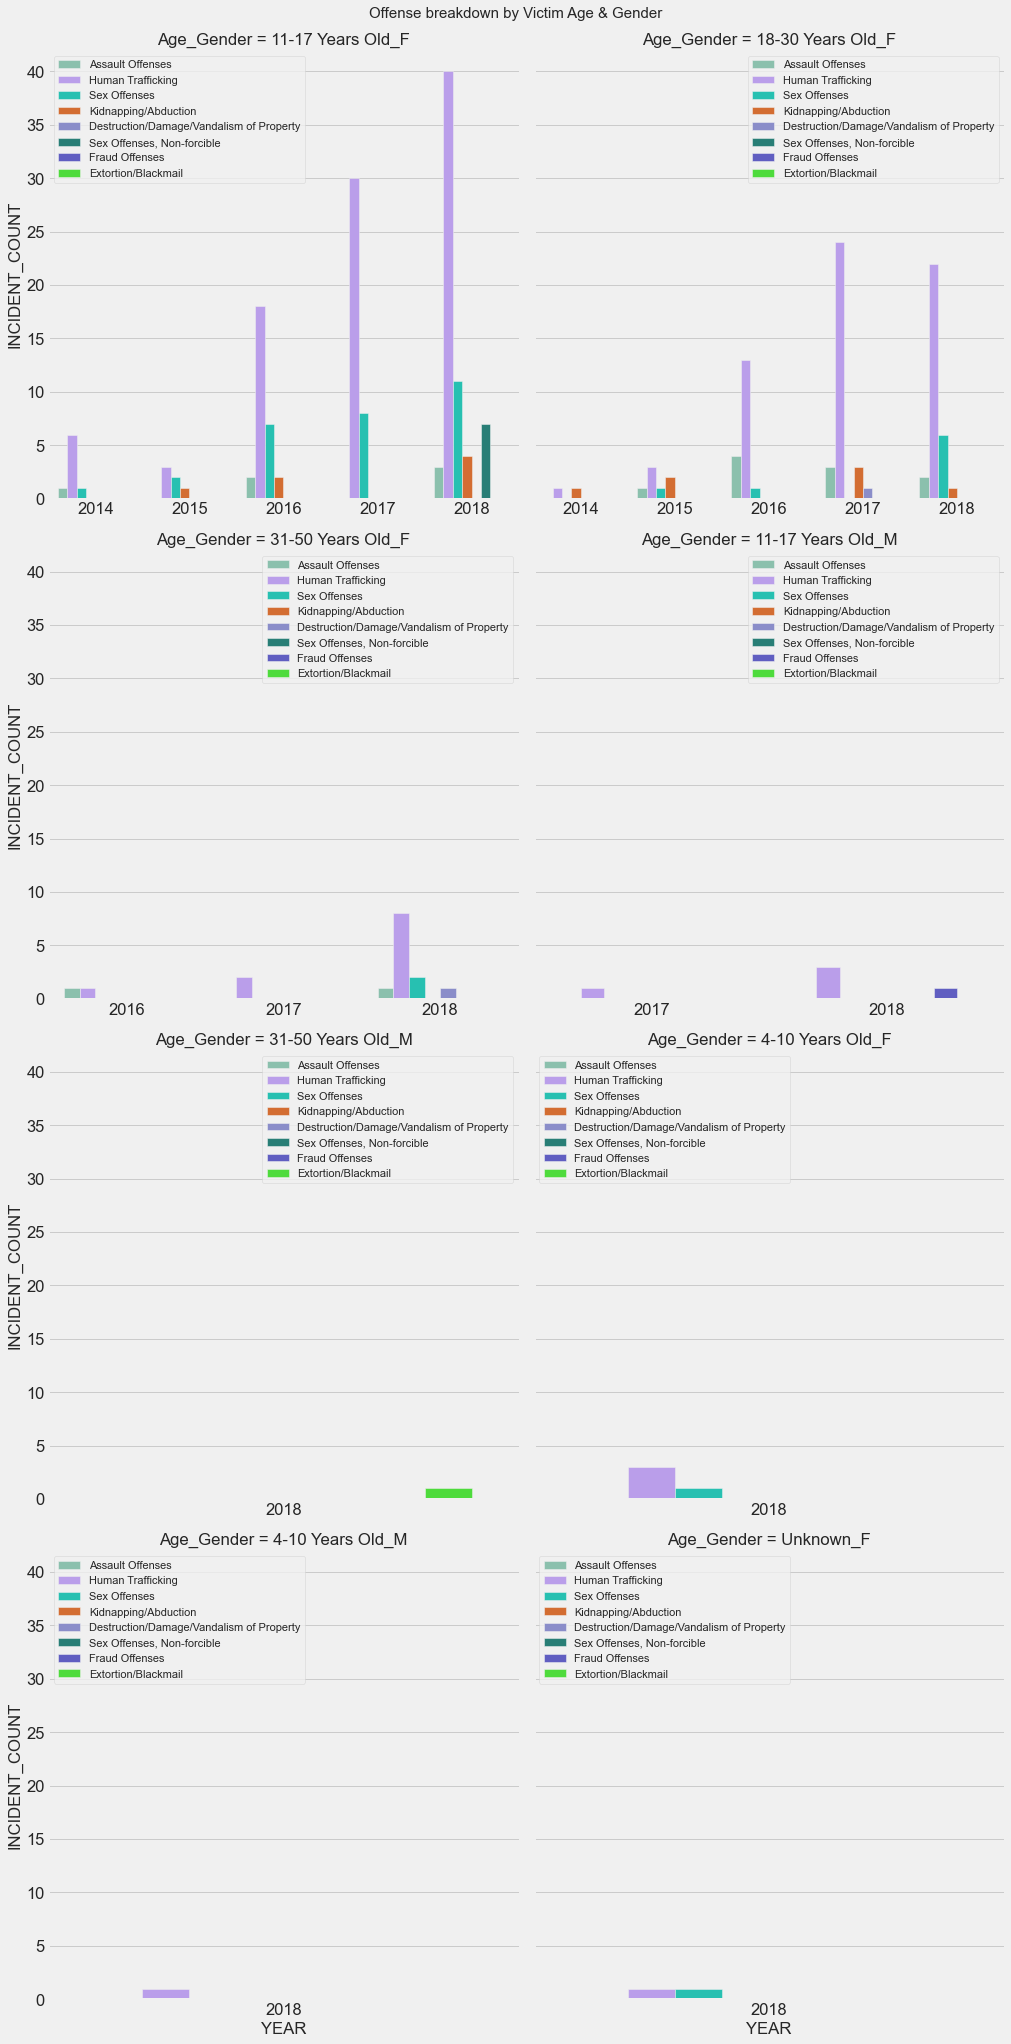

In [18]:
# Set the bar graph style
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

vic_agegp_sex = victims_df.groupby(['YEAR', 'Age_Group', 'VICTIM_SEX_CODE', 'OFFENSE_CATEGORY_NAME'], as_index = True)['INCIDENT_ID'].nunique()
vic_agegp_sex = pd.DataFrame(vic_agegp_sex).reset_index()
vic_agegp_sex = vic_agegp_sex.rename(columns = {'INCIDENT_ID':'INCIDENT_COUNT'})
vic_agegp_sex['Age_Gender'] = vic_agegp_sex['Age_Group'] + '_' + vic_agegp_sex['VICTIM_SEX_CODE']

# generate random colors
random.seed(5)
generate_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = generate_colors(vic_agegp_sex['OFFENSE_CATEGORY_NAME'].nunique())

# Plot
oc = sns.catplot(x = 'YEAR', y = 'INCIDENT_COUNT', col = 'Age_Gender', hue = 'OFFENSE_CATEGORY_NAME',
                 data = vic_agegp_sex, sharex = False, sharey = True, kind = 'bar', height = 7, aspect=1, 
                 col_wrap = 2, legend_out=False, palette=sns.color_palette(colors))

for ax in oc.axes.ravel():
    ax.legend(fontsize=11, loc='best')

oc.fig.suptitle('Offense breakdown by Victim Age & Gender', x = 0.5, y= 1.005, fontsize = 15)

## 5. Victims-Offenders Connections

This section tries to find out the connection between victims and offenders. <br>

<b>NOTES:</b><br>
Users can change the value of variables to adjust the filter in below lines:<br>
<b>Default value:</b><br>
connection_count = 3<br>
year = 2018<br>

<b> Instructions for using the graph</b>

In below interactive graphs, users can:
- mouse over the edge (line) to see the OffenderID & VictimID
- click the connected nodes to highlight the connected path between victims and offenders
- Zoom & reset the graph
- nodes size is normalised according to the number of connections

<b> Legend </b>
- Blue dots - Victims
- Grey dots - Offenders
- Red dots - Offenders who have many connections with victims, configurable by users
- Grey edge - the connection between offenders and victims, i.e. incident

In [19]:
# Set variables for filtering
offender_count = 5
connection_count = 3
year = 2018


# 1. Count of offense_name in a single incident
offenses['Offender_Count'] = offenses.groupby(['INCIDENT_ID'])['OFFENDER_ID'].transform('nunique')


# 2. Extract multiple offenders incidents
# Currently it extracts incidents involving multiple offenders.
index_names = offenses[(offenses['Offender_Count'] == 1)].index
multi_offenders = offenses.drop(index_names, inplace=False)


## 3. Subset the data by year
multi_offenders = multi_offenders[multi_offenders['YEAR'] == year]


## 4. Extract those incidents with at least 5 offenders
multi_offenders = multi_offenders[multi_offenders['Offender_Count'] >= offender_count]


## 5. Plot an interactive graph on notebook
from bokeh.io import output_notebook, show, output_file, reset_output
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool, LinearColorMapper, ColumnDataSource,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool, BoxZoomTool, ResetTool, Triangle, 
                          LegendItem, Legend)
from bokeh.palettes import Spectral4, Category10
from bokeh.plotting import from_networkx, figure

import time
import networkx as nx


# Create the graph
Graph = nx.DiGraph()
g = nx.from_pandas_edgelist(multi_offenders, source='OFFENDER_ID', target='VICTIM_ID', edge_attr='INCIDENT_ID', 
                            create_using= Graph)

plot = figure(title="Offender-Victim Connection Demonstration", x_range=(-2.2,2.5), y_range=(-2.2,2.5),
              tools="", toolbar_location="right")


# Calculate node size
node_sizes = []
minFound = 1
maxFound = 10


# Look for the min, max degree
for node in g:
    if node in multi_offenders["VICTIM_ID"].values or \
       node in multi_offenders["OFFENDER_ID"].values:
        size = float(g.degree(node))
        minFound = min(minFound, size)
        maxFound = max(maxFound, size)
        

# Define node colors according to the roles & Define node name for the legend 
colors = []
node_names = []
node_sizes = []

for node in g.nodes():
    if node in multi_offenders["VICTIM_ID"].values:
        colors.append("lightblue")
        node_names.append("Victims")
    elif node in multi_offenders["OFFENDER_ID"].values and g.degree(node) > connection_count:
        colors.append("red")
        node_names.append("Highly Connected Offenders")
    elif node in multi_offenders["OFFENDER_ID"].values: 
        colors.append("grey")
        node_names.append("Offenders")
    else:
        print("Error: The node should be either offender or victim!")
        continue
    
    # Calculate the scaled size
    s = float(g.degree(node))
    size = (s - minFound) / (maxFound - minFound)
    scaled_size = 10 + size * 5
    node_sizes.append(scaled_size)


graph_renderer = from_networkx(g, nx.spring_layout, scale=2, center=(0,0))


# add victims & offenders to node data
graph_renderer.node_renderer.data_source.data['colors'] = colors
graph_renderer.node_renderer.data_source.data['node_names'] = node_names
graph_renderer.node_renderer.data_source.data['node_sizes'] = node_sizes


# set node colors
graph_renderer.node_renderer.glyph = Circle(size='node_sizes', fill_color='colors', name = 'node_names')
graph_renderer.node_renderer.selection_glyph = Circle(size=8, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=8, fill_color=Spectral4[1])


# Draw edge
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=3, line_join='miter')
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=3, line_join='miter')
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=3, line_join='miter')


# set policies
graph_renderer.selection_policy = EdgesAndLinkedNodes()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()


# Add tools
edge_tooltips = [('OffenderID', '@start'),
                 ('VictimID', '@end')]
edge_hover_tool = HoverTool(renderers=[graph_renderer], tooltips = edge_tooltips, show_arrow = True)

plot.add_tools(edge_hover_tool, TapTool(), BoxSelectTool(), BoxZoomTool(), ResetTool())


# Add legend
plot.circle(legend_field='node_names', source=graph_renderer.node_renderer.data_source.data, color = 'colors')
plot.legend.location = 'top_right'

plot.renderers.append(graph_renderer)


reset_output()
output_notebook()
show(plot)

Loading BokehJS ...

## 6. Victim-Offender Relationships

It analyses the relationships between victims and offenders.

<b>NOTES:</b><br>
Users can change the value of variables, if necessary, to adjust the filter in below lines:<br>
<b>Default Value</b><br>
year = 2018<br>
offense_category = 'Human Trafficking'

<b> Instructions for using the graph</b>

In below interactive graphs, users can:
- mouse over the edge (line) to see the OffenderID & VictimID
- click the connected nodes to highlight the connected path between victims and offenders
- Zoom & reset the graph
- nodes size is normalised according to the number of connections

#### Legend
- Blue dots - Victims
- Grey dots - Offenders
- Edges - Relationship between an victim and an offender

In [20]:
# Set filter variables
year = 2018
offense_category = 'Human Trafficking'


## 1. Drop rows with no relationship information
vic_off_relations = offenses.dropna(subset = ['Relationship_Family'])


## 2. Filter data
vic_off_relations = vic_off_relations[vic_off_relations['YEAR'] == year]
vic_off_relations = vic_off_relations[vic_off_relations['OFFENSE_CATEGORY_NAME'] == offense_category]


## 3. Plot an interactive graph on notebook
from bokeh.io import output_notebook, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool, BoxZoomTool, ResetTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

import networkx as nx


# Create the graph
DiGraph = nx.DiGraph()
g1 = nx.from_pandas_edgelist(vic_off_relations, source='OFFENDER_ID', target='VICTIM_ID', 
                             edge_attr='Relationship_Family', create_using= DiGraph)

plot = figure(title="Offender-Victim Relationships Demonstration", x_range=(-2.2,2.5), y_range=(-2.2,2.5),
              tools="", toolbar_location="right")


# Calculate node size
node_sizes = []
minFound = 1
maxFound = 10


# Look for the min, max degree
for node in g1:
    if node in vic_off_relations["VICTIM_ID"].values or \
       node in vic_off_relations["OFFENDER_ID"].values:
        size = float(g1.degree(node))
        minFound = min(minFound, size)
        maxFound = max(maxFound, size)


# Define node colors according to the roles & Define node name for the legend 
colors = []
node_names = []
node_sizes = []

for node in g1.nodes():
    if node in vic_off_relations["VICTIM_ID"].values:
        colors.append("lightblue")
        node_names.append("Victims")
    elif node in vic_off_relations["OFFENDER_ID"].values: 
        colors.append("grey")
        node_names.append("Offenders")
    else:
        print("Error: The node should be either offender or victim!")
        continue
        
    # Calculate the scaled size
    s = float(g1.degree(node))
    size = (s - minFound) / (maxFound - minFound)
    scaled_size = 10 + size * 5
    node_sizes.append(scaled_size)


# Create a bokeh graph renderer
graph_renderer_rel = from_networkx(g1, nx.spring_layout, scale=2, center=(0,0))


# Define Edge color
edge_color = []
for edge in graph_renderer_rel.edge_renderer.data_source.data['Relationship_Family']:
    if edge == 'Within Family':
        edge_color.append('blue')
    elif edge == 'Outside Family But Known to Victim':
        edge_color.append('pink')
    elif edge == 'Not Known By Victim':
        edge_color.append('lightgreen')
    elif edge == 'Other':
        edge_color.append('lightbrown')
    else:
        edge_color.append('purple')
#         print('Error: The edge should fall in one of the categories')

        
graph_renderer_rel.node_renderer.data_source.data['colors'] = colors
graph_renderer_rel.node_renderer.data_source.data['node_names'] = node_names
graph_renderer_rel.node_renderer.data_source.data['node_sizes'] = node_sizes

graph_renderer_rel.node_renderer.glyph = Circle(size='node_sizes', fill_color='colors')
graph_renderer_rel.node_renderer.selection_glyph = Circle(size=8, fill_color=Spectral4[2])
graph_renderer_rel.node_renderer.hover_glyph = Circle(size=8, fill_color=Spectral4[1])


graph_renderer_rel.edge_renderer.data_source.data['edge_color'] = edge_color

graph_renderer_rel.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=3)
graph_renderer_rel.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=3)
graph_renderer_rel.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=3)


# set policies
graph_renderer_rel.selection_policy = EdgesAndLinkedNodes()
graph_renderer_rel.inspection_policy = EdgesAndLinkedNodes()


# Add tools
edge_tooltips = [('Offender', '@start'),
                 ('Victim', '@end')]
edge_hover_tool = HoverTool(renderers=[graph_renderer_rel], tooltips = edge_tooltips, show_arrow = True)

plot.add_tools(edge_hover_tool, TapTool(), BoxSelectTool(), BoxZoomTool(), ResetTool())


# Add legend
plot.circle(legend_field='node_names', source=graph_renderer_rel.node_renderer.data_source.data, color = 'colors')
plot.circle(legend_field='Relationship_Family', source = graph_renderer_rel.edge_renderer.data_source.data, color = 'edge_color')

plot.legend.location = 'top_right'
plot.legend.label_text_font_size = "8px"


plot.renderers.append(graph_renderer_rel)


reset_output()
output_notebook()
show(plot)



Loading BokehJS ...